In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import torch

from tqdm import tqdm
from scipy import stats

from src.utils import ratemap_collage, weighted_kde, SimpleDatasetMaker
from src.models import RecurrentSpaceNet, Decoder, End2End

plt.style.use("figures/project_style.mplstyle")

In [2]:
## Training parameters
train_steps = 50000
timesteps = 20
bs = 32 # batch size

# Model parameters
n_in = 2 # Cartesian coordinates, no context
n_out = 100 # no. of spatial representations
scale = 0.3

In [3]:
# instantiate RNN model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = RecurrentSpaceNet(n_in = n_in, n_out = n_out, corr_across_space= True,
                          scale = scale, device = device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

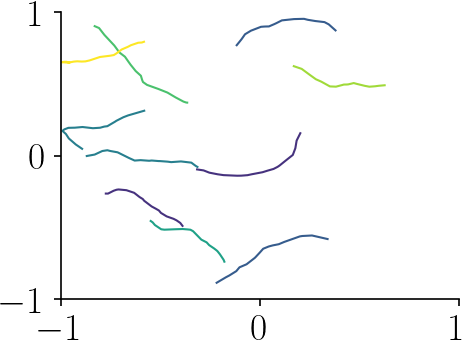

In [4]:
genny = SimpleDatasetMaker() # use simple dataset
r, v = genny.generate_dataset(10, timesteps)
plt.plot(*r.detach().numpy().T)
plt.axis([-1, 1, -1, 1])
plt.show()

In [5]:
loss_history = []
progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    r_label = r[:,1:]
    loss = model.train_step(x = (v, r[:,0]), y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        loss_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.001066: 100%|██████████| 50000/50000 [04:57<00:00, 167.96it/s]


Text(0, 0.5, 'Train Loss')

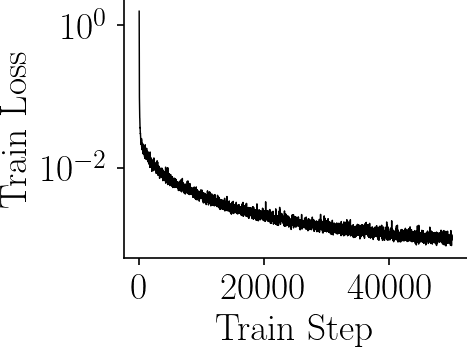

In [6]:
plt.semilogy(np.arange(len(loss_history))*10, loss_history, "-k", linewidth = 0.7)
plt.xlabel("Train Step")
plt.ylabel("Train Loss")

In [9]:
decoder = Decoder(n_in = n_out, n_out = 2) # train decoder
optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-4)

In [10]:
decoder_history = []

progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)

    # Train decoder on data from RNN model 
    p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
    p = p.detach() 
    p = torch.reshape(p, (-1, p.shape[-1]))
    r_label = r[:,1:].reshape(-1, 2)
    # labels are just Cartesian coordinates
    loss = decoder.train_step(x = p, y = r_label, optimizer = optimizer)

    if i % 10 == 0:
        decoder_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000131: 100%|██████████| 50000/50000 [01:54<00:00, 438.03it/s]


In [ ]:
end_to_end = End2End(n_in = n_in, n_out = n_out) # train end to end
optimizer = torch.optim.Adam(end_to_end.parameters(), lr=1e-4)

In [ ]:
e2e_history = []

progress = tqdm(range(train_steps))
for i in progress: # train loop
    r, v = genny.generate_dataset(bs, timesteps, device = device)
    loss = end_to_end.train_step(x = (v, r[:,0]), y = r[:,1:], optimizer = optimizer)

    if i % 10 == 0:
        e2e_history.append(loss)
        progress.set_description(f"loss: {loss:>7f}")

loss: 0.000018: 100%|██████████| 50000/50000 [02:46<00:00, 300.12it/s]


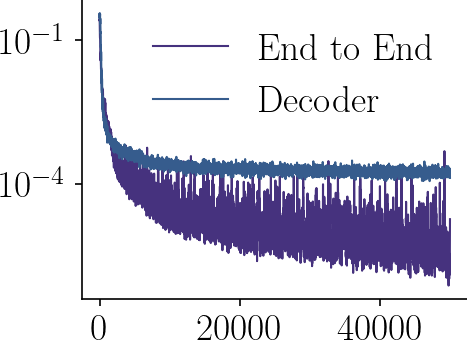

In [ ]:
# plot loss histories for comparable models
plt.semilogy(np.arange(len(e2e_history))*10, e2e_history, label = "End to End")
plt.semilogy(np.arange(len(decoder_history))*10, decoder_history, label = "Decoder")
plt.legend(frameon = False)

In [61]:
# evaluate both model to visualize prediction error
n_eval = 5000
r, v = genny.generate_dataset(n_eval, timesteps, device = device)

e2e_pred = end_to_end((v, r[:,0])).detach().numpy()
error = np.linalg.norm(e2e_pred - r[:,1:].detach().numpy(), axis = -1)
e2e_error = error.reshape(n_eval, timesteps-1)

p = model.spatial_representation(v, model.p0(r[:,0])[None])[0].detach()
decoder_pred = decoder(p).detach().numpy()
decoder_error = np.linalg.norm(decoder_pred - r[:,1:].detach().numpy(), axis = -1)
decoder_error = decoder_error.reshape(n_eval, timesteps - 1)

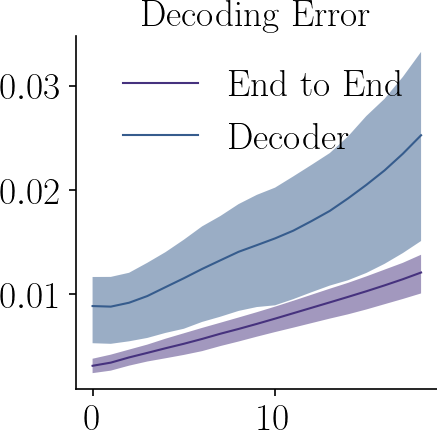

In [66]:
plt.figure(figsize=(3,3))
plt.title("Decoding Error")
e2e_quartiles = np.percentile(e2e_error, [25, 75], axis = 0)
decoder_quartiles = np.percentile(decoder_error, [25, 75], axis = 0)

plt.plot(np.mean(e2e_error, axis = 0), label = "End to End")
plt.plot(np.mean(decoder_error, axis = 0), label = "Decoder")
plt.fill_between(np.arange(timesteps - 1), e2e_quartiles[0], e2e_quartiles[1], alpha = 0.5)
plt.fill_between(np.arange(timesteps - 1), decoder_quartiles[0], decoder_quartiles[1], alpha = 0.5)

plt.legend()
#e2e_quartiles, e2e_quartiles

tensor([[ 0.3250, -0.8901],
        [ 0.3451, -0.9043],
        [ 0.3626, -0.9071],
        [ 0.3773, -0.9118],
        [ 0.3919, -0.9280],
        [ 0.4178, -0.9433],
        [ 0.4524, -0.9881],
        [ 0.4917, -0.9588],
        [ 0.5121, -0.9504],
        [ 0.5581, -0.9292],
        [ 0.5613, -0.9283],
        [ 0.5784, -0.9242],
        [ 0.5982, -0.9121],
        [ 0.6717, -0.9209],
        [ 0.6933, -0.9346],
        [ 0.7211, -0.9309],
        [ 0.7456, -0.9172],
        [ 0.7673, -0.9001],
        [ 0.7802, -0.8918],
        [ 0.8028, -0.8787]])


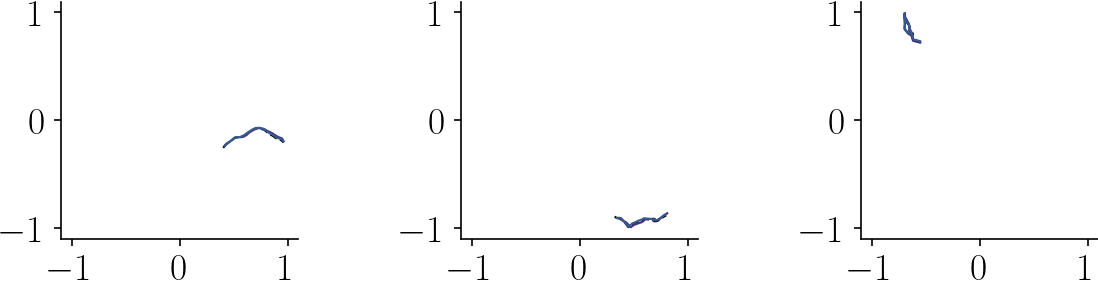

In [113]:
fig, ax = plt.subplots(1, 3, figsize = (8,2))
for i in range(len(ax)):
    ax[i].plot(*r[i].T, "k--")
    ax[i].plot(*decoder_pred[i].T)
    ax[i].plot(*e2e_pred[i].T)
    ax[i].set_aspect("equal")
    ax[i].axis([-1.1, 1.1, -1.1, 1.1])
#legend(["True", "Decoder", "End to End"])
print(r[1])

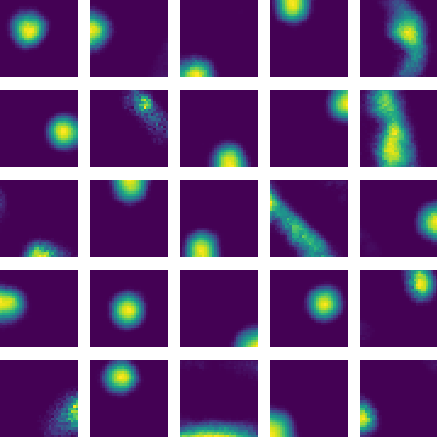

In [40]:
# visualize representations
n_plot = 5000 # number of plot trajectories
n_show = 25 # number of units to show
r, v = genny.generate_dataset(n_plot, timesteps)

# BSR 
p,_ = model.spatial_representation(v, model.p0(r[:,0])[None])
p = p.detach().numpy()
ps = p.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:25], cols = 5, figsize = (3,3))

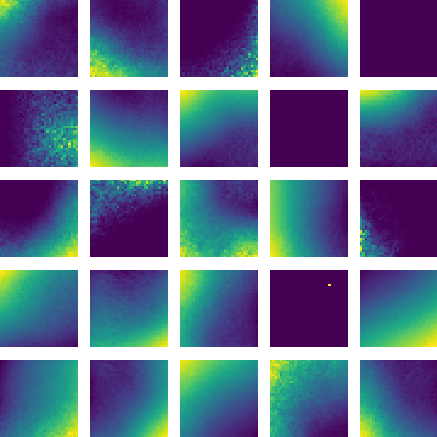

In [39]:
# End to end representations
p_e2e,_ = end_to_end.spatial_representation(v, end_to_end.p0(r[:,0])[None])
p_e2e = p_e2e.detach().numpy()

ps_e2e = p_e2e.reshape(-1, p.shape[-1])
rs = r[:,1:].detach().numpy().reshape(-1, 2)
ratemaps, _, _, _ = stats.binned_statistic_2d(rs[:,0], rs[:,1],ps_e2e.T, bins = 32)
fig, ax = ratemap_collage(ratemaps[:n_show], cols = int(np.sqrt(n_show)), figsize = (3,3), constrained_layout = True)